# Tarea 2
## Francisco Javier Peralta Ramírez

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

import warnings
sp.init_printing()
warnings.filterwarnings('ignore')

In [397]:
def nag(f, gradf, x0, nIter, alpha, eta):
    assert alpha > 0 and eta > 0#positive step size
    a, e, x = alpha, eta, x0
    #primer paso es desenso de gradiente...
    p = gradf(x)
    fx = [f(x)]
    x = x - a * p
    #empieza NAG
    fx.append(f(x))
    for i in range(nIter - 1): #ya hicimos la primera iteracion...
        xn = x - a * p #tomamos el paso anterior
        gt = gradf(xn)
        p = e * p + gt #nueva dir
        x = xn - a * p
        fx.append(f(x))
    print(x)
    return np.array(fx)

In [398]:
def adagrad(f, gradf, x0, nIter, alpha, epsilon = 0.001):
    x = x0
    g2 = np.zeros_like(x)
    fx = [f(x)]
    for i in range(nIter):
        g = gradf(x)
        g2 += g**2 #suma cuadrada de gradientes
        n = alpha / np.sqrt(g2 + epsilon)
        x = x - n * g
        fx.append(f(x))
    print(x)
    return np.array(fx)

In [399]:
def adam(f, gradf, x0, nIter, alpha, beta = (0.9, 0.999), epsilon = 1E-8):
    x = x0
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    fx = [f(x)]
    
    for i in range(nIter):
        g = gradf(x)
        m = beta[0] * m + (1 - beta[0]) * g    #decaying avg momentum
        v = beta[1] * v + (1 - beta[1]) * g**2 #decaying velocity
        #bias corrected first and second moments
        mh = m / ( 1 - beta[0])
        vh = v / ( 1 - beta[1])
        x = x - alpha * mh / (np.sqrt(vh) + epsilon)
        fx.append(f(x))
    print(x)
    return fx

Codificamos la función rosembrock como un simple **for**

In [103]:
def rosenbrock(x):
    fx = 0
    for i in range(len(x) - 1):
        fx += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return fx

Como la función *rosenbrock* admite cualquier tipo (i.e. no se hace chequeo de tipos) podemos pasar simbolos de *sympy*

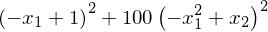

In [104]:
x = sp.symbols('x1:3')
rosenbrock(x)

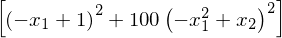

In [105]:
ros = sp.Matrix([rosenbrock(x)])
ros

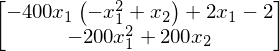

In [106]:
jacRos = ros.jacobian(x).T
jacRos

Podemos evaluar el resultado del gradiente usando la función **subs** la cual substituye las variables por valores, esta requiere un parámetro de la forma ***[ (old, new), ... ]*** donde *old* es la variable a remplazar y *new* el valor.

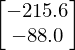

In [127]:
x0 = [-1.2, 1]
evalJ = jacRos.subs([(x[i], x0[i]) for i in range(len(x0))])
evalJ

Podemos juntar todo esto para crear una función que regresa el gradiente

In [159]:
def sym_grad(f, x):
    x_s = sp.symbols('x0:{}'.format(len(x)))
    mtx = sp.Matrix([f(x_s)])
    jac = mtx.jacobian(x_s)
    evl = jac.subs([(x_s[i], x[i]) for i in range(len(x0))])
    return np.array( [float(v) for v in evl])
sym_grad(rosenbrock, x0) #comprobamos funcionamiento

#mucho mas rapido con lamdify
def sym_grad2(f, k):
    x_s = sp.symbols('x0:{}'.format(k))
    mtx = sp.Matrix([f(x_s)])
    jac = mtx.jacobian(x_s)
    jac_f  = [sp.lambdify(x_s, jac[i]) for i in range(k)]
    def __gradient(x):
        return np.array([ jac_f[i](*x) for i in range(k)])
    return __gradient

def sym_grad_batch(f, x, syms):
    pass

In [165]:
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))

In [166]:
nag(rosenbrock, rosenbrock_grad, x0, 10, 0.001, 0.2)

array([24.2       ,  5.35291158, 10.53256361,  4.45291231,  3.95323557,
        3.95010693,  3.93548183,  3.92231644,  3.91257388,  3.90424358,
        3.89611101])

In [167]:
adagrad(rosenbrock, rosenbrock_grad, x0, 10, 0.1)

array([24.2       ,  5.6200002 ,  4.42773308,  4.28313775,  4.26158791,
        4.25630733,  4.25326015,  4.25052384,  4.24783087,  4.24514378,
        4.24245728])

In [168]:
adam(rosenbrock, rosenbrock_grad, x0, 10, 0.1)

Comparamos los resultados de **NAG, ADAGRAD, ADAM** para *Rosenbrock* con $n = 2$ y $x_0 = [-1.2, 1]$

In [169]:
def plot_res(nag_res, adagrad_res, adam_res):
    f, ax = plt.subplots(1, 2, figsize=(24, 8))

    ax[0].plot(nag_res, label="NAG")
    ax[0].plot(adagrad_res, label="ADAGRAD")
    ax[0].plot(adam_res, label="ADAM")
    ax[0].legend()

    ax[1].plot(nag_res)
    ax[1].plot(adagrad_res)
    ax[1].plot(adam_res)
    ax[1].set_xlim(n_iter - 10, n_iter)
    ax[1].set_ylim(-0.0001, np.ceil(adagrad_res[-1]))
    plt.show()

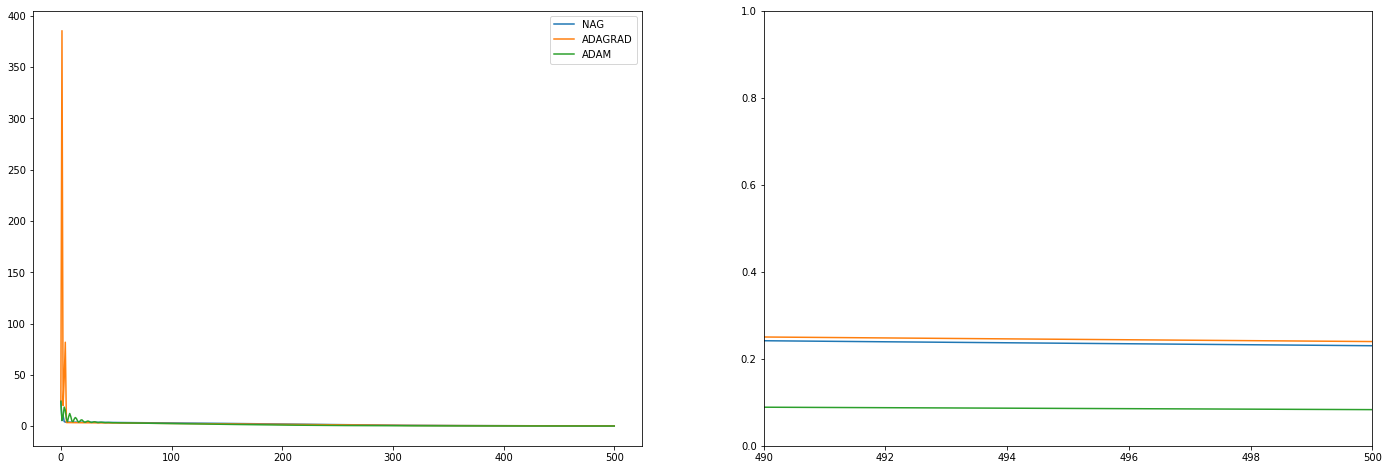

NAG: 0.23003097789834537	ADAGRAD: 0.23963264994036995	ADAM: 0.0830723551658313
CPU times: user 276 ms, sys: 6.98 ms, total: 283 ms
Wall time: 284 ms


In [170]:
%%time
x0 = [-1.2, 1]
n_iter = 500
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))
nag_res = nag(rosenbrock, rosenbrock_grad, x0, n_iter, 0.001, 0.2)
adagrad_res = adagrad(rosenbrock, rosenbrock_grad, x0, n_iter, 1)
adam_res = adam(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)

plot_res(nag_res, adagrad_res, adam_res)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[-1], adagrad_res[-1] , adam_res[-1]))

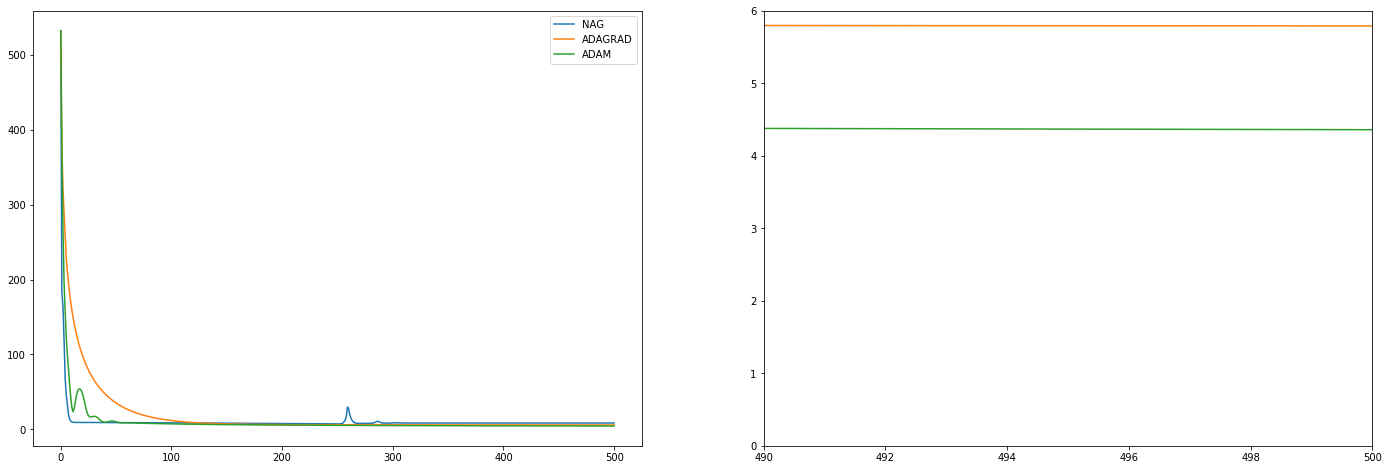

NAG: 8.387514565612117	ADAGRAD: 5.792575982598245	ADAM: 4.36104322889238
CPU times: user 280 ms, sys: 2 ms, total: 282 ms
Wall time: 281 ms


In [172]:
%%time
x0 = np.ones((10))
x0[0] = x0[-2] = -1.2
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))
n_iter = 500
nag_res = nag(rosenbrock, rosenbrock_grad, x0, n_iter, 0.001, 0.2)
adagrad_res = adagrad(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)
adam_res = adam(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)

plot_res(nag_res, adagrad_res, adam_res)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[-1], adagrad_res[-1] , adam_res[-1]))

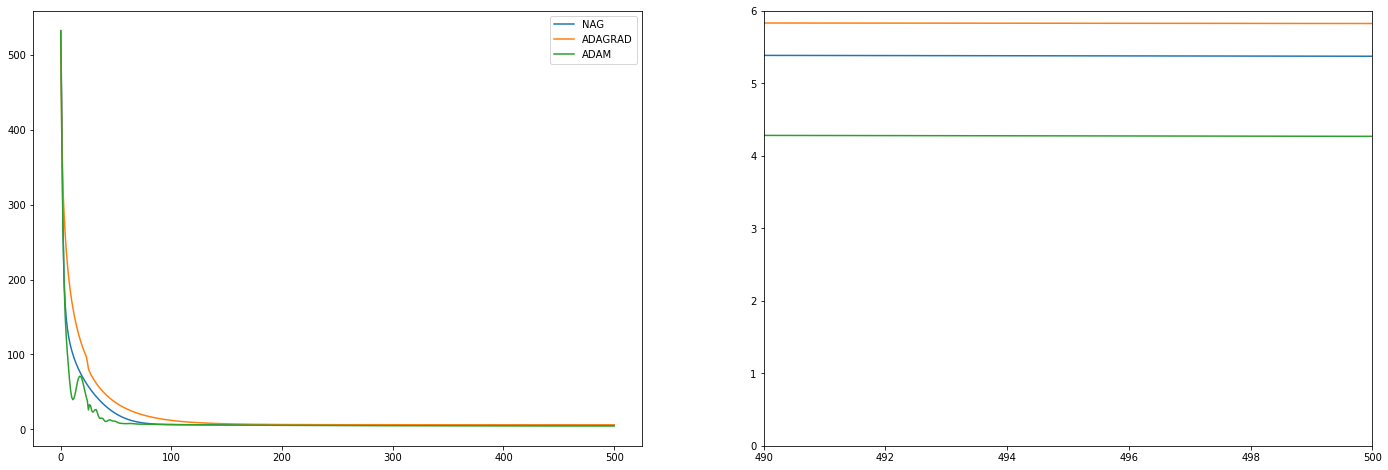

NAG: 5.374595393504411	ADAGRAD: 5.826391996524356	ADAM: 4.269714209561028
CPU times: user 783 ms, sys: 2.97 ms, total: 786 ms
Wall time: 790 ms


In [174]:
%%time
x0 = np.ones((50))
x0[0] = x0[-2] = -1.2
rosenbrock_grad = sym_grad2(rosenbrock, len(x0))
n_iter = 500
nag_res = nag(rosenbrock, rosenbrock_grad, x0, n_iter, 0.0001, 0.2)
adagrad_res = adagrad(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)
adam_res = adam(rosenbrock, rosenbrock_grad, x0, n_iter, 0.1)

plot_res(nag_res, adagrad_res, adam_res)
print("NAG: {0}\tADAGRAD: {1}\tADAM: {2}".format(nag_res[-1], adagrad_res[-1] , adam_res[-1]))

In [39]:
data = np.load('data.npy')

In [195]:
def radial_gauss(x, mu, sigma, lib=sp):
    expv = (x - mu)**2 / (2 * sigma**2)
    return lib.exp(expv)

def radial_fit(x, mu, sigma, c, lib=sp):
    val = c[0]
    for i in range(len(mu)):
        val += c[i+1] * radial_gauss(x, mu[i], sigma[i], lib)
    return val

def radial_err(x, y, mu, sigma, c, lib=sp):
    err = 0
    for i in range(len(y)):
        err += (radial_fit(x[i], mu, sigma, c, lib) - y[i])**2
    return err

def create_radial_err_fun(x, y, msc):
    def fun(val):
        k = int(np.floor(len(msc)/3))
        mu, sigma, c = msc[:k], msc[k:2*k], msc[2*k:]
        errf = radial_err(x, y, mu, sigma, c, sp)
        errL = sp.lambdify(msc, errf)
        return errL(*val)
    return fun

In [196]:
radial_err(data[:10, 0], data[:10, 1], np.array([0, 1, 2]), np.array([1, 2, 3]), np.array([0, 1, 2, 3]))

In [42]:
k = 3
c = sp.symbols('c0:{}'.format(k + 1))
mu = sp.symbols('m0:{}'.format(k))
sigma = sp.symbols('s0:{}'.format(k))

v = np.array(c+mu+sigma)
np.random.shuffle(v)
v

array([m0, s2, s0, c2, m1, c0, c3, c1, s1, m2], dtype=object)

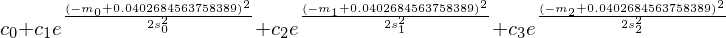

In [43]:
radial_fit(data[1:2, 0][0], mu ,sigma, c, sp)

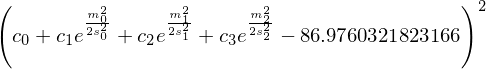

In [44]:
radial_err(data[:1, 0], data[:1, 1], mu ,sigma, c, sp)

In [385]:
def radial_err_pdif(x, y, mu, sigma, c):
        """mask: a bookean array that indicates the 
        symbols we need to derive with respect to.
        Derivatives wil be wrt mu, then sigma then c"""
        fun = radial_err(x, y, mu, sigma, c, sp) #use sympy
        partials = [0] * (len(mu) * 3 + 1)
        k = 0
        for i in range(len(mu)):
            partials[k] = sp.diff(fun, mu[i])
            k +=1
        for i in range(len(sigma)):
            partials[k] = sp.diff(fun, sigma[i])
            k +=1
        for i in range(len(c)):
            partials[k] = sp.diff(fun, c[i])
            k +=1
        return partials
    
def create_radial_err_pdif_fun(x, y, msc):
    k = int(np.floor(len(msc)/3))
    mu, sigma, c = msc[:k], msc[k:2*k], msc[2*k:]
    errdif  =  radial_err_pdif(x, y, mu, sigma, c)
    errdifL = [sp.lambdify(msc, errdif[i]) for i in range(len(msc))]
    def fun(val, mask):
        return np.array([errdifL[i](*val) if mask[i] else 0 for i in range(len(val))])
    return fun

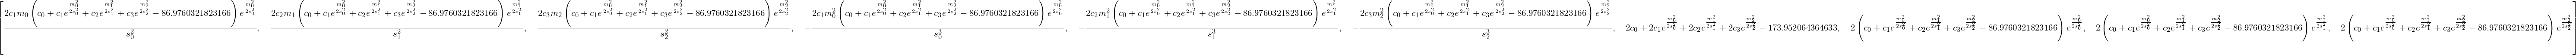

In [384]:
radial_err_pdif(data[:1, 0], data[:1, 1], mu, sigma, c)

In [386]:
def nag_batch(f, gradf, x0, nIter, alpha, eta):
    assert alpha > 0 and eta > 0#positive step size
    a, e, x = alpha, eta, x0
    #primer paso es desenso de gradiente...
    p = gradf(x)
    fx = [f(x)]
    xn = x - a * p
    #empieza NAG
    if(f(xn) < f(x)):
        x = xn
    fx.append(f(x))
    for i in range(nIter - 1): #ya hicimos la primera iteracion...
        xn = x - a * p #tomamos el paso anterior
        gt = gradf(xn)
        p = e * p + gt #nueva dir
        xn = xn - a * p
#         if(f(xn) < f(x)):
        x = xn
        fx.append(f(x))
    print(x)
    return np.array(fx)

In [415]:
%%time
x, y = data[:, 0], data[:, 1]
msc = (mu + sigma + c)
gradf = create_radial_err_pdif_fun(x, y, msc)
f = create_radial_err_fun(x, y, msc)
x0 = np.append(np.random.choice(6, 3, replace=False), [1, 1, 1, 1, 1, 1, 1])
# x0 = [0.5, 2.5, 5, 1, 1, 1, 1, 1, 1, 1]

CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 31.7 µs


In [422]:
%%time
a = nag(f, gradf, x0, 50, 0.0001, 0.1)
print(a)

[ 1.68875688e+08  1.84060646e+04 -1.57103328e+05  9.03196957e+08
  5.91415820e+04  7.44329863e+05  2.36226854e+04 -3.15537843e+07
  1.94155377e+04 -9.10458607e+03]
[3.91149379e+13 3.14440592e+16 1.38623435e+17 1.53426571e+17
 1.54845238e+17 1.54884035e+17 1.54784481e+17 1.54671112e+17
 1.54556357e+17 1.54441427e+17 1.54326410e+17]
CPU times: user 34.4 s, sys: 4.97 ms, total: 34.4 s
Wall time: 34.5 s


In [427]:
%%time
b = adagrad(f, gradf, x0, 10, 0.1)
print(a)

[0.61557865 2.64627646 4.79578021 1.11453711 1.14370755 1.20384362
 0.77854456 0.87932515 0.83667975 0.79373811]
[39114937907868.22, 81250840094.40611, 228914400.17086333, 5886578.918037169, 1082173.8575172776, 953811.1485055595, 1034201.5445622929, 1097566.389578937, 1139615.84386556, 1168100.712224164, 1188303.6857542025]
CPU times: user 34.7 s, sys: 9.74 ms, total: 34.7 s
Wall time: 34.8 s


In [428]:
%%time
c = adam(f, gradf, x0, 10, 0.1)
print(a)

[1.15497335 3.1658337  4.3427649  1.65470739 1.66429219 1.65674433
 0.27901829 0.34410395 0.32861782 0.34101312]
[39114937907868.22, 81250840094.40611, 228914400.17086333, 5886578.918037169, 1082173.8575172776, 953811.1485055595, 1034201.5445622929, 1097566.389578937, 1139615.84386556, 1168100.712224164, 1188303.6857542025]
CPU times: user 34.4 s, sys: 21.7 ms, total: 34.4 s
Wall time: 34.5 s


In [421]:
def create_radial_err_pdif_fun(x, y, msc, batch=30):
    p = [i for i in range(len(data))]
    def fun(val):
        idxs = np.random.choice(p, batch)
        k = int(np.floor(len(msc)/3))
        mu, sigma, c = msc[:k], msc[k:2*k], msc[2*k:]
        errdif  =  radial_err_pdif(x[idxs], y[idxs], mu, sigma, c)
        errdifL = [sp.lambdify(msc, errdif[i]) for i in range(len(val))]
        return np.array([errdifL[i](*val) for i in range(len(val))])
    return fun

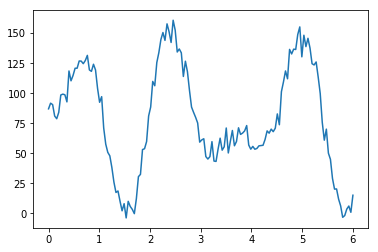

In [322]:
plt.plot(x, y)

In [379]:
def create_radial_err_pdif_fun(x, y, msc, batch=20):
    p = [i for i in range(len(data))]
    def fun(val):
        idxs = np.random.choice(p, batch)
        k = int(np.floor(len(msc)/3))
        mu, sigma, c = msc[:k], msc[k:2*k], msc[2*k:]
        errdif  =  radial_err_pdif(x[idxs], y[idxs], mu, sigma, c)
        errdifL = [sp.lambdify(msc, errdif[i]) for i in range(len(val))]
        return np.array([errdifL[i](*val) for i in range(len(val))])
    return fun

test = create_radial_err_pdif_fun(x, y, msc)

In [400]:
test(x0)

array([  578.18073428,   304.4174446 ,  -130.07092627, -1772.28296327,
          66.63279405,    81.89377444,  -980.23084853, -1060.43945182,
       -1023.14090818, -1006.39102765])

In [343]:
p = [i for i in range(len(data))]
idx = np.random.choice(p, 10)

In [362]:
p = [i for i in range(len(data))]
idxs = np.random.choice(p, 20)
idxs

array([ 94, 105,  10,  59, 144,  19, 148,   2,  41,  42,  60,  58, 108,
        81,  42,  97,  98, 109,  37, 126])

In [410]:
np.append(np.random.choice(6, 3, replace=False), [1, 1, 1, 1, 1, 1, 1]).shape